# Individual Analysis - Compton Scattering

The tasks for this experiment's analysis:

1. Prior to working on this noetbook, obtain the peak positions of the main photopeaks in the calibration data sets and the positions and full-width at half maxima of the photopeaks in the Compton scattering data.  Also obtain the integrated area of the photopeaks for the Compton scattering cross section data sets.  Then create these arrays:
   * Energy vs. photopeak position for the calibration data.
   * Scattering angle vs. peak position for the Compton scattering data.
   * Plastic thickness vs. photopeak area (net counts) for the cross section data.


2. Make a line fit to the calibration data to convert channel number to energy in MeV.  Save the calibration coefficients.


3. Create a function that will give the predicted channel number as a function of angle for the Compton-scattered photopeaks.  Then plot this prediction along with the measured photopeak positions (in channel numbers).


4. Convert the photopeak positions and FWHM for the Compton scattering data to energy units, using the calibration coefficients.


5. Create a fitting function, based on the expected energy vs. angle, for Compton scattering.  There should be one fit parameter: the incident energy of the gamma ray.  Use this function in the LMFIT `Model` to carry out a fit of the theoretical formula to the data.  Compare the fitted incident energy to the known incident energy from the Cs-137 source.


6. For the total scattering cross section, plot the photopeak net area (i.e., integrated counts) versus plastic thickness (in cm) on a single-log axis (vertical).  Fit this data set (either with a line to the log of the counts, or with an exponential decay to the counts) to obtain the gamma-attenuation coeffient $\mu$ (in cm<sup>-1</sup>) for Lucite plastic.  Then calculate the scattering cross-section per electron by means of the chemical data for Lucite (i.e., divide out the number of electrons per cm<sup>3</sup>).  

In [26]:
import numpy as np  # import the numpy library functions.
import scipy.constants as const # import physical constants
import matplotlib.pyplot as plt # plotting functions
import uncertainties as unc # Uncertainties package.  Good for simple error propagation
# directive below puts the plots in the notebook
%matplotlib inline

## 1. Build the data arrays

### Build the calibration arrays

You may use the energies you recorded in the Energy Measurements lab here, but the channel data will be different.

In [27]:
cal_channel = np.array([29, 120, 172, 221])
cal_energy = np.array([0.081, 0.356, 0.511, 0.662])

### Build the Angle vs. Energy arrays

Print the data (a table is nice) to make sure you have it correctly.

In [28]:
angles = np.array([20, 25, 30, 40, 50, 60, 70, 80, 90,
                   100, 110, 120, 130, 140])
energies = np.array([220, 197, 189, 170, 153, 135, 121, 108,
                     98, 89, 83, 77, 73, 69])

from prettytable import PrettyTable
table = PrettyTable()

table.field_names = ['Angle', 'Channel']

if angles.size == energies.size: #make sure both arrays are same length
    for i in np.arange(angles.size):
        table.add_row([angles[i], energies[i]])

print(table)

+-------+---------+
| Angle | Channel |
+-------+---------+
|   20  |   220   |
|   25  |   197   |
|   30  |   189   |
|   40  |   170   |
|   50  |   153   |
|   60  |   135   |
|   70  |   121   |
|   80  |   108   |
|   90  |    98   |
|  100  |    89   |
|  110  |    83   |
|  120  |    77   |
|  130  |    73   |
|  140  |    69   |
+-------+---------+


### Build the thickness vs. Peak counts arrays

In [29]:
thickness = np.array([0, 2.46, 4.94, 7.42, 10.89, 15.55, 20.20])
peak_counts = np.array([168196, 136553, 110995, 84824, 60580, 37608, 24612])
error = np.sqrt(peak_counts)

## 2. Obtain the calibration

### Fit to a line

Fit the calibration data.

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 4
    # variables        = 2
    chi-square         = 4.7298e-06
    reduced chi-square = 2.3649e-06
    Akaike info crit   = -50.5916548
    Bayesian info crit = -51.8190660
[[Variables]]
    slope:      0.00302141 +/- 1.0813e-05 (0.36%) (init = 0.003021409)
    intercept: -0.00690094 +/- 0.00165472 (23.98%) (init = -0.006900939)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.885

Slope =  0.003021409147095178 +/- 1.081343765883162e-05


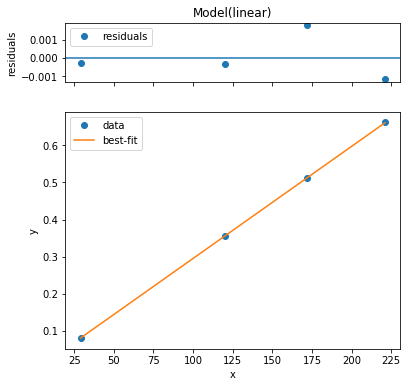

In [30]:
from lmfit.models import LinearModel

line = LinearModel()

param_guess = line.guess(cal_energy, x=cal_channel)

line_fit = line.fit(cal_energy, param_guess, x=cal_channel)

print(line_fit.fit_report())

print('\nSlope = ', line_fit.params['slope'].value, '+/-', line_fit.params['slope'].stderr)

line_fit.plot();

### Save the calibration coefficients

In [31]:
slope = line_fit.params['slope'].value
intercept = line_fit.params['intercept'].value

## 3. Calculate the expected channel position as a function of angle

Write a function, given the channel position of the Cs-137 gamma energy, the scattering angle, and the known energy of the Cs-137 gamma ray that returns the expected channel postion of the Compton-scattered peak.  Then print a table of these positions at angles 20, 30, ..., 140 degrees.

The energy vs. angle formula, from Leo section 2.7:

$$E^{\prime}_{\gamma} = \frac{E_{\gamma}}{1+\frac{E_{\gamma}}{m_0c^2}\left(1-\cos\theta\right)}$$

So if the scattering angle is zero, the scattered energy $E_{\gamma}^{\prime}$ equals the incident energy $E_{\gamma}$. The channel numbers should be proportional to the energy.

In [32]:
def expCompPeak(angle, channel=221, energy=0.662):
    m_e = const.m_e
    c = const.c
    theta = angle * 2*const.pi/360 #convert angle to radians
    
    bot = 1 + (energy/(m_e*c**2 * 6.242e12) * (1-np.cos(theta))) #denominator
    e_prime = energy / bot #exp energy
    ch_exp = e_prime * channel / energy #convert energy to channel num
    return ch_exp


from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ['Angles', 'Exp. Position (Ch #)']

expCompPeaks = [] #save array of exp compton scatter peak locations

for i in np.arange(angles.size):
    expPos = expCompPeak(angles[i])
    expCompPeaks.append(expPos)
    table.add_row([angles[i], round(expPos)])
    
print(table)

+--------+----------------------+
| Angles | Exp. Position (Ch #) |
+--------+----------------------+
|   20   |        205.0         |
|   25   |        197.0         |
|   30   |        188.0         |
|   40   |        170.0         |
|   50   |        151.0         |
|   60   |        134.0         |
|   70   |        119.0         |
|   80   |        107.0         |
|   90   |         96.0         |
|  100   |         88.0         |
|  110   |         81.0         |
|  120   |         75.0         |
|  130   |         71.0         |
|  140   |         67.0         |
+--------+----------------------+


## Plot expected positions to measured positions

Use `plt.errorbar()` to plot the FWHM as error bars on the measured peak positions.

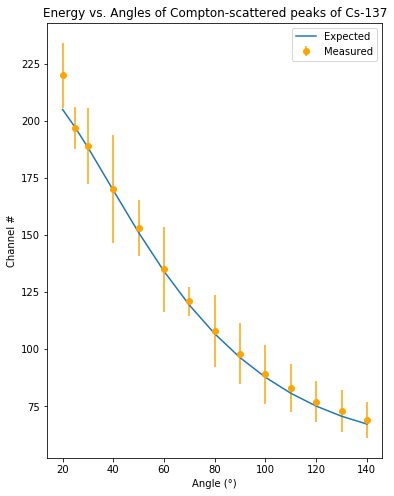

In [33]:
fwhm = np.array([14.2, 9.2, 16.8, 23.7, 12.3, 18.7, 6.3, 15.6, 13.4, 12.8, 10.3, 8.9, 9.1, 7.9])
expCompPeaks = np.array(expCompPeaks)
plt.figure(figsize=(6, 8))
plt.plot(angles, np.array(expCompPeaks), label='Expected')
plt.errorbar(angles, energies, yerr=fwhm, fmt='o', color='orange', label='Measured')
plt.title('Energy vs. Angles of Compton-scattered peaks of Cs-137')
plt.ylabel('Channel #')
plt.xlabel(u'Angle (\N{DEGREE SIGN})')
plt.legend();

## 4. Convert channels to energy

Use the calibration coefficients found earlier to convert channel numbers to energy in MeV.  Convert both peak positions and peak widths.

In [34]:
def calibrate(channel, m=slope, b=intercept):
    val = m * channel + b
    return val
energies_cal = calibrate(energies)
fwhm_cal = calibrate(fwhm)
expPeaks_cal = calibrate(expCompPeaks)

## 5. Fit the data to the Compton scattering prediction

Use the basic LMFIT `Model` to build a "model" around the Compton scattering predition for scattered energy vs. scattering angle.

[[Model]]
    Model(expCompPeak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 14
    # variables        = 2
    chi-square         = 0.00133150
    reduced chi-square = 1.1096e-04
    Akaike info crit   = -125.647121
    Bayesian info crit = -124.369007
[[Variables]]
    channel:  0.68075616 +/- 0.00825134 (1.21%) (init = 0.6608305)
    energy:   0.69968146 +/- 0.02436644 (3.48%) (init = 0.662)
[[Correlations]] (unreported correlations are < 0.100)
    C(channel, energy) =  0.820


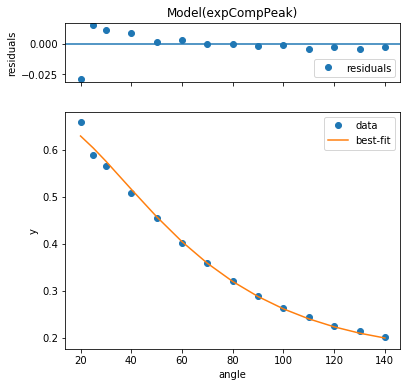

In [35]:
from lmfit import Model

model = Model(expCompPeak)
x_vals = np.arange(0,150)
model_fit = model.fit(energies_cal, angle=angles, channel=calibrate(221))

print(model_fit.fit_report())
model_fit.plot();

### Print the fitted energy

In your Group Document, compare this to the expected gamma energy

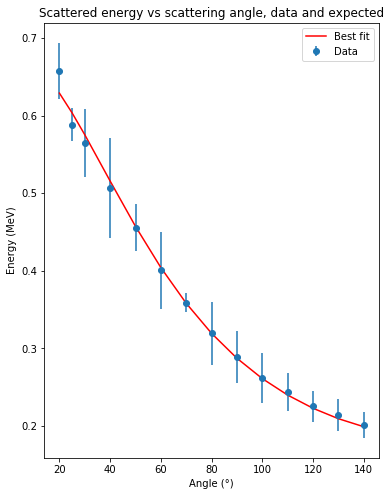

In [36]:
plt.figure(figsize=(6,8))
plt.errorbar(angles, energies_cal, yerr=fwhm_cal, fmt='o', label='Data')
plt.plot(angles, model_fit.best_fit, color='red', linestyle='-', label='Best fit')
plt.title('Scattered energy vs scattering angle, data and expected')
plt.ylabel('Energy (MeV)')
plt.xlabel(u'Angle (\N{DEGREE SIGN})')
plt.legend();

## 6. Analyze the total cross-section data

### Plot the photopeak area vs. plastic thickness

On a semilog scale (vertical) it should look linear.

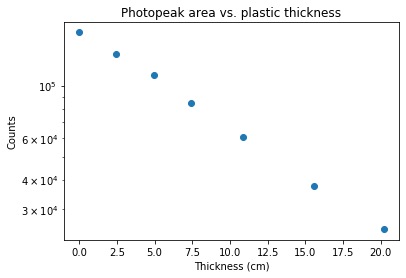

In [37]:
plt.errorbar(thickness, peak_counts, yerr=error, fmt='o')
plt.title('Photopeak area vs. plastic thickness')
plt.ylabel('Counts')
plt.xlabel('Thickness (cm)')
plt.yscale('log')

### Fit the data to obtain the absorption coefficient $\mu$

Either fit a line to the log of the photopeak area, or an exponential to the un-modified data, and obtain the coefficient (what are the units?).

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 7
    # variables        = 2
    chi-square         = 0.00249067
    reduced chi-square = 4.9813e-04
    Akaike info crit   = -51.5878086
    Bayesian info crit = -51.6959883
[[Variables]]
    slope:     -0.09671228 +/- 0.00125887 (1.30%) (init = -0.09671228)
    intercept:  12.0606494 +/- 0.01390426 (0.12%) (init = 12.06065)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.795
Absorption Coefficient = 0.0967+/-0.0013


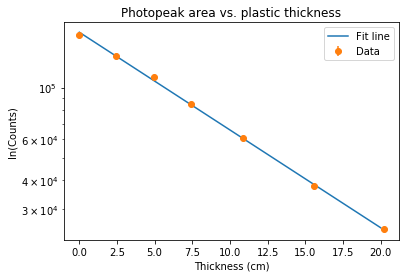

In [38]:
from lmfit.models import LinearModel

adj_peak_counts = np.log(peak_counts) #adjust peak_counts with log scale

model = LinearModel()

param_guess = model.guess(adj_peak_counts, x=thickness) #init guesses

model_fit = model.fit(adj_peak_counts, param_guess, x=thickness) #get model fit 
print(model_fit.fit_report())


#revert count vals, and plot fitline and data on log scale
x_vals = np.arange(0, 21) #some range of length
y_vals = model_fit.eval(x=x_vals) #get yvals for above xvals
plt.plot(x_vals, np.exp(y_vals), label='Fit line') 
plt.errorbar(thickness, peak_counts, yerr=error, fmt='o', label='Data')
plt.title('Photopeak area vs. plastic thickness')
plt.ylabel('ln(Counts)')
plt.xlabel('Thickness (cm)')
plt.yscale('log')
plt.legend();

#obtain absorption coefficient from model (slope of linear model)
coeff = model_fit.params['slope'].value
coeff_err = model_fit.params['slope'].stderr

absp_coeff = -unc.ufloat(coeff, coeff_err)

print('Absorption Coefficient = {:.uf}'.format(absp_coeff))

### Obtain $\mu$ and calculate $\sigma_C$

From the fit result, obtain the absorption coefficient.  Then from the chemical composition of Lucite (acrylic plastic), determine the electron density, and use this to calculate the total Compton scettering cross section per electron.  Compare this result to the Klein-Nishina equation prediction, either from the graph in Leo or calculation from the formula.  

In [39]:
e_dens = 1.18/100 * const.N_A * 54
cross_sec = absp_coeff/e_dens
cross_sec_barn = cross_sec / 10**-24
print('Total Compton scattering cross section per electron = {:.uf} barn/electron'.format(cross_sec_barn))

Total Compton scattering cross section per electron = 0.2520+/-0.0033 barn/electron
